# Classifying All-NBA Players (Part IV - Logistic Regression)
Okay. So last time, we tried looking at LDA and QDA in addition to our manually chosen linear decision boundary to classify if players are all-NBA team worthy or not. We got the following results:
- Manually chosen linear decision boundary - 93% / 92% accuracy for all-NBA / non all-NBA respectively
- LDA - 69% / 98% accuracy for all-NBA / non all-NBA respectively
- QDA - 73% / 98% accuracy for all-NBA / non all-NBA respectively

Decent results. Not the greatest. These two dont touch the accuracy I've been able to get with my manually selected linear decision boundary (post 19).

I'm going to try another model to see if we can see any improvement. I'm just kinda going down the list one by one, so I'll skip to logistic regression next.

## Logistic Regression
Okay, so how the hell does logistic regression work... Let's start with one perdictor and a classification outcome. For this, I'm going to refer to a [youtube video](https://www.youtube.com/watch?v=zAULhNrnuL4) that I found quite useful in solidifying my basic understanding.

We start with a single predictor model and 2 classes of prediction. We have a credit score and are trying to determine how this credit score affects the our probabilities of getting approved for a... loan I think it was in the video?

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/logreg/1example.png" width="400">

Above is the scatterplot for what this would look like _**assuming a quantitative representaton**_ of our output classes. Here, we've assigned _**1 as approve**_ and _**0 as deny**_. This then _**could**_ become a linear regression problem, pretending our results are quantitative results.

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/logreg/2examplelinreg.png" width="400">

The problems with the results mainly revolve around the fact that, well, here the result can go above 1 and below 0, in fact it can go to infinity and negative infinity! What does a probability of infinity mean (and in this example the y variable really isn't even a probability)? We've already capped out on the definition of probability at 0 and 1! We can in fact still use linear regression, and just make a decision that anything p > 0.6 we will approve, or something like that, but the problem is that linear regression works on the basis of _**least squares**_ as a measurement of model performance.

In the credit score example above, calculating least squares would be simply unreasonable because the number of samples in each class would affect the RSS value being calculated. Wherever there is a large density of samples will draw the line of best fit to cross through that cluster because having the line close to there will minimize the RSS being calculated. Also, let's say the line extends way beyond to where p = 0 or p = 1, and let's say we get to a score where p gets up to like 10. The RSS at this point will be extremely skewed because the error isn't representative of the model accuracy. The error would be extremely large, but the prediction is actually great... there should be an error of zero!

Logistic regression takes the maximum likelihood approach, and we use the _**logit**_ function to model the relationship between x and y.

The _**logit**_ function provides some great properties in a probability setting. For starters,

$$F(\infty)=1$$
$$F(-\infty)=0$$

and this is exactly what we want. Having our y variable bound between 0 and 1 mimics the probability properties we're looking for.

A logit looks like this:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/logreg/3logit.png" width="200">

$$logit(p)=ln(odds)=ln(\frac{p}{1-p})$$

This isn't constraining our y-variable to one yet, but the inverse does:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/logreg/4inverselogit.png" width="400">

$$logit^-1(p)=\frac{1}{1+e^{-\alpha}}=\frac{e^{\alpha}}{1+e^{\alpha}}$$

This thing is now allowing us to actually view our dependent variable as a probability. It also satisfies the way we actually model a probability of an outcome with two possible results.

$$P(Y=y_i|X)=[P(Y=y_i|X)]^{y_i}[1-(P(Y=y_i|X))^{1-y_i}]$$

Which is kind of just a fancy way of saying

$$P(Y=1|X)=P(Y=1|X)$$
$$P(Y=0|X)=1-P(Y=1|X)$$

Our linear regression model wouldn't have played by this rule either as at any given moment, the total probability doesn't equal to 1. In the logit function, the total probability among the two classes at any given point in x _**is always 1**_!.

If we then apply this logit function to our credit score data set, we now have something alongside the data representing probabilities of each class, and it's quite a bit more intuitive for us to understand and visualize:

<img src="https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/logreg/5examplelogreg.png" width="400">

Now, we take this logit function and make it relate to our input variables in _**A LINEAR FASHION**_. If we have the following linear combination of variables

$$\beta_0+\beta_1x$$

and we relate it to

$$logit(p)=\frac{p}{1-p}=\beta_0+\beta_1x$$

We are essentially saying that _**every unit increase in x1 will result in a consistent increase in the log-odds of the predictor**_. That was definitely a lot of words, but maybe for a quick example, let's say that our model indicates that every unit increase of x1 causes an increase in log-odds of 2. This, in plain english, means that _**every 1 point increase in our credit score increases our odds of getting approved by 2**_. This means that if we're currently sitting at a score of 600 and we have 8:1 odds of getting approved, having 601 will give us 4:1 odds. These are clearly fictional numbers as one point would never double your chances of getting approved, but hopefully it demonstrates the idea here. Note that we are not saying the _**probability changes**_, we are saying that the _**log-odds change**_.

An iterative approach is then taken to fit the coefficients to the best model.

## Logistic Regression on All-NBA Data
Okay let's grab our data frame again and run it through logistic regression.

In [1]:
# Load libraries & initial config
%load_ext rpy2.ipython

%R library(ggplot2)
%R library(gridExtra)
%R library(scales)
%R library(ggbiplot)
%R library(dplyr)

%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Retrieve team stats from S3
playerAggDfAllNbaAllStar = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfAllNbaAllStar.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfAllNbaAllStar.dtypes))
print playerAggDfAllNbaAllStar.dtypes
pd.reset_option('display.max_rows')

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

In [3]:
%%R -i playerAggDfAllNbaAllStar -o playerAggDfAllNbaAllStarCoefs

# Fit model
allNbaLogReg = glm(accolades_all_nba ~ advancedStats_WS + advancedStats_VORP, data = playerAggDfAllNbaAllStar, family = binomial(link = 'logit'))

# Store coefficients in dataframe to view back in python
playerAggDfAllNbaAllStarCoefs = as.data.frame(summary(allNbaLogReg)$coefficients)

In [4]:
# View model coefficents
print playerAggDfAllNbaAllStarCoefs

                    Estimate  Std. Error    z value       Pr(>|z|)
(Intercept)         8.984069    0.284663  31.560340  1.293465e-218
advancedStats_WS   -0.728820    0.045611 -15.978872   1.793621e-57
advancedStats_VORP -0.220985    0.072176  -3.061760   2.200399e-03


Okay, before I go even into any other metrics of the model or ANYTHING else, I just want to make sense of the coefficients just so I'm aware of what these numbers are saying.

Let's look at win shares first. What's this saying... it's saying a 1 unit increase in win shares is _**decreasing**_ the log-odds of... _**something**_ by 0.73. Oh man... that's alot to think about... let's break it down a bit more. There's 2 things going on here.

#### 1 Unit Increase in Win Shares Decreases Log-Odds by 0.73
We know that

$$ln(\frac{p}{1-p})=\beta_0+\beta_1x_1$$

The _**odds**_ of something happening when there are only 2 outcomes can be seen as

$$\frac{p}{1-p}$$

right? If we have a coin flip, our odds are

$$\frac{0.5}{1-0.5}=\frac{1}{1}$$

or 1 to 1 for both outcomes.

If we picking marbles out of a bag, 3 of which are blue, and 1 of which is green, our odds of picking the blue marbles are

$$\frac{\frac{3}{4}}{1-\frac{3}{4}}=\frac{\frac{3}{4}}{\frac{1}{4}}=\frac{3}{1}$$

or 3 to 1 odds. At this point, of course, the green would be 1 to 3 odds.

So back to win shares... We know that _**1 unit increase in win shares decreases log-odds by 0.73**_.

$$ln(\frac{p}{1-p})=-0.73$$
$$\frac{p}{1-p}=e^{0.73}=2.08$$

We must remember that this is the _**odds**_ that we are changing, which is a function of the probability. The probability itself follows the s-shaped logit function right? So from different parts of the curve, _**the probability itself may change more drastically or less drastically with every unit change in win share, but the odds themselves will always be proportional with every unit change in win share.**_

I mentioned probability... well... that leads us to my second observation:

_**Which Probability are we Referring to?**_
A unit change in win shares changes the odds by 2.08, which is a function of probability... but... the probability of what? Because this is a relatively simple classification, I can assume that this is the probability of being a non all-NBA team member. This is only because I know that a higher win share decreases your chances of being an non all-NBA team member... duh... but what if I didnt know the data so well?

I'm not sure if I have an answer for this at the moment other than using my intuition about the data. I think a clearer way for me to perform this modelling would be to explicitly classify the categories into 0 and 1, and then regress on that coded variable. Here, it's easy enough to 'assume', which will be confirmed soon anyways so I will leave it.

So what exactly do we do when we predict using this model?

In [5]:
# Perform prediction
%R predict(allNbaLogReg, playerAggDfAllNbaAllStar[c('advancedStats_WS', 'advancedStats_VORP')])

array([-3.30516116,  7.50433114,  3.10888355, ...,  8.27734795,
        8.85381729,  8.20446597])

I got an array of numbers... which I can only assume is... log-odds? Uhh I have no clue lol. After googling a bit, it seems that prediction has a _**type**_ parameter that allows us to contextualize the response.

In [6]:
# Perform prediction
%R predict(allNbaLogReg, playerAggDfAllNbaAllStar[c('advancedStats_WS', 'advancedStats_VORP')], type = 'response')

array([ 0.03539456,  0.99944961,  0.9572577 , ...,  0.99974585,
        0.99985718,  0.99972665])

Those look a lot more like probabilities, that's for sure. I'll know plotting it and seeing if it follows the pattern.

In [7]:
# Add predictions to dataframe
%R playerAggDfAllNbaAllStar['log_reg_pred'] = predict(allNbaLogReg, playerAggDfAllNbaAllStar[c('advancedStats_WS', 'advancedStats_VORP')], type = 'response')

array([ 0.03539456,  0.99944961,  0.9572577 , ...,  0.99974585,
        0.99985718,  0.99972665])

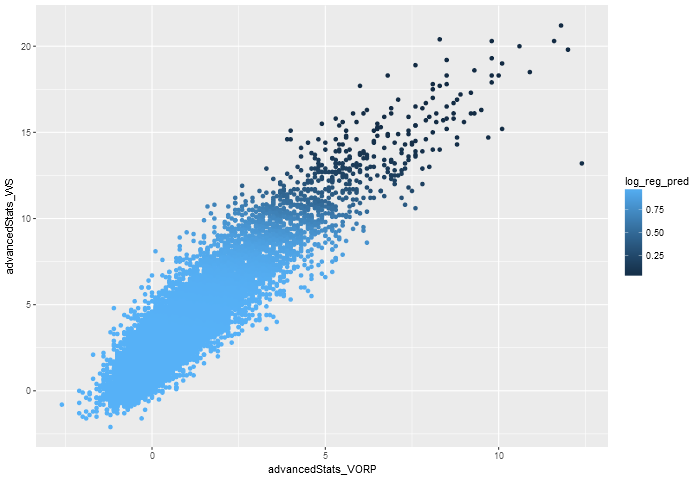

In [8]:
%%R -w 700 -u px

# Plot WS vs VORP scatter with predictions colored in
allNbaPlotLinReg = ggplot(
    NULL
) +
geom_point(
    data = playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = log_reg_pred
    )
)

allNbaPlotLinReg

This looks pretty good. We see the gradient start to change around that WS = 8 mark. Remember that WS = 7.5 was basically the minimum WS that we saw from all-NBA team members.

Let's see the original plot again to remind ourselves what that looked like.

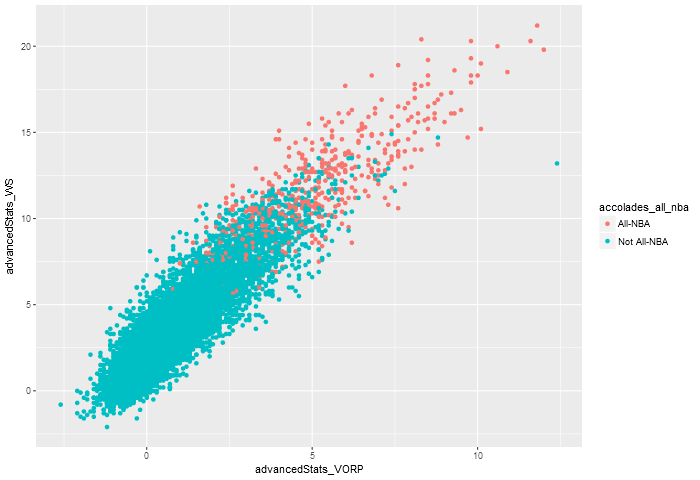

In [9]:
%%R -w 700 -u px

# Plot WS vs VORP scatter with predictions colored in
allNbaPlot = ggplot(
    NULL
) +
geom_point(
    data = playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = accolades_all_nba
    )
)

allNbaPlot

In the linear regression plot, we can really see the probabilities take the shape of an S-curve, with the curve part of the plot taking place around WS = 10 and VORP = 4. The S curve follows WS a bit more actually, an interesting observation.

Okay, so we have probabilities of what's what. Do we just assume that anything over a 50% probability is non all-NBA and under  is all-NBA? Let's try it out!

In [10]:
# Classify anything above 50% not all-NBA and under 50% all-NBA
%R playerAggDfAllNbaAllStar['log_reg_pred_classified_50_50'] = ifelse(playerAggDfAllNbaAllStar['log_reg_pred'] >= 0.5, 'Not All-NBA', 'All-NBA')

array(['All-NBA', 'Not All-NBA', 'Not All-NBA', ..., 'Not All-NBA',
       'Not All-NBA', 'Not All-NBA'], 
      dtype='|S11')

In [11]:
%R logReg5050ConfMatrixTbl = table(playerAggDfAllNbaAllStar[['log_reg_pred_classified_50_50']], playerAggDfAllNbaAllStar[['accolades_all_nba']])
%R logReg5050ConfMatrixDf = as.data.frame(logReg5050ConfMatrixTbl)

,Var1,Var2,Freq
1,All-NBA,All-NBA,268
2,Not All-NBA,All-NBA,234
3,All-NBA,Not All-NBA,76
4,Not All-NBA,Not All-NBA,12642


In [12]:
%R sum(diag(logReg5050ConfMatrixTbl)) / sum(logReg5050ConfMatrixTbl)

array([ 0.97655068])

Overall, the model gets 97.7% of the results correct, but remember how many non all-NBA players there are? Even if you just always guessed non all-NBA you'd still be at like 95% accuracy, so how much better is this than always guessing non all-NBA? What we'd end up doing now is re-analyzing the model having the cutoff at different points and finding which cutoff gives the best results. This sounds kind of familiar... oh wait, it is. It's _**basically what I was doing by moving the y-intercepts in our manual line model**_! I'm basically moving the boundary causing the classification process to be more or less forgiving to certain categories, right?

There is a library called ROCR that gives us some really easy tools to perform this analysis... much... MUCH quicker than what I did before...

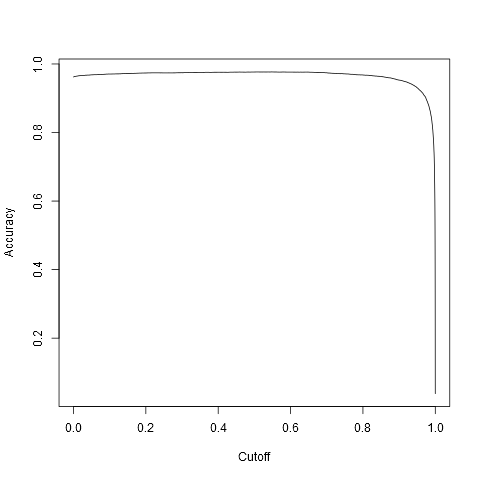

In [13]:
# The ROCR package provides us with many tools to gauge accuracy of classification models
%R library(ROCR)

# Perform prediction
%R linRegPredObj = prediction(playerAggDfAllNbaAllStar['log_reg_pred'], playerAggDfAllNbaAllStar['accolades_all_nba'])

# Run performance evaluation for the metric 'total accuracy'
%R linRegEval = performance(linRegPredObj, 'acc')
%R plot(linRegEval)

Mm, ok. Took me a bit to get my bearings there and understand exactly what the hell is happening in this plot... I'm just following a [youtube tutorial](https://www.youtube.com/watch?v=ypO1DPEKYFo) by the way... I have never heard of the ROCR package, nor have I thought this much about ROC curves in general until now.

This plot is gauging _**total accuracy**_ like we were doing before. 

At the very left of the plot, this is the situation where we say anybody with 0% probability or up is a non all-NBA team member, aka _**everybody is a non all-NBA team member (aka no one made the all-NBA team)**_. Again, when we classify everybody as an all-NBA team member, we're still like 95%< correct because so much of the data is non all-NBA! We see we have to literally get up to cutting ourselves off at like 0.9 probability to even begin to go under 90% total accuracy...

At the right of the plot, when we say _**everyone made the all-NBA team**_, we see the accuracy go down to... wel... pretty much 0. This is because we're only getting 500 some odd people correc out of over 30k! Not that many people make the all-NBA team each year, so to just blindly guess all-NBA for every single person is a horrible approach.

Clearly, this curve isn't really useful to us in determining the best model. We want great accuracy in _**both**_ classes! This curve, however, does have sort of a _**hump at around cutoff = 0.5**_... so maybe our random guess at 0.5 was right after all!

ROCR also has tools to help us look at accuracy by class as well.

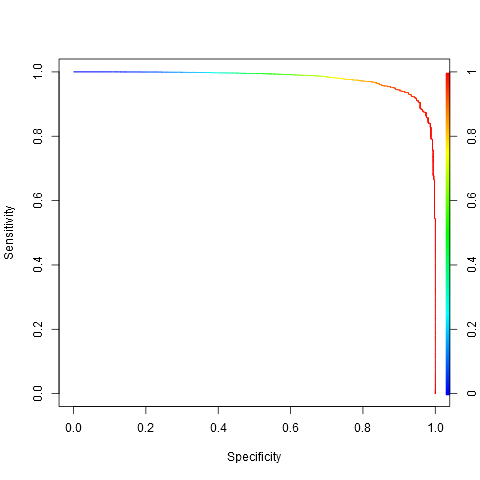

In [14]:
# Run performance evaluation for the metrics 'true positive rate' and 'false positive rate'
%R linRegRocEval = performance(linRegPredObj, 'sens', 'spec')
%R plot(linRegRocEval, colorize = T)

A few terms to define here...
- _**True Positive Rate**_ - Otherwise known as the sensitivity, the TPR is the amount of 1's that the model will classify as a 1 (in this case, the percentage of non all-NBA players the model guessed correctly)
- _**False Positive Rate**_ - Otherwise known as 1-specificity, the FPR is the amount of 0's that the model will classify as a 1 (in this case, the percentage of non all-NBA players the model guessed incorrectly)

Basically, the ROC curve is just demonstrating the trade off that we have in this model. With my straight line, we saw that there was a sweet spot where both classes were guessing quite successfully, and that's when we ended up with 93% / 92% for all-NBA / non all-NBA respectively.

I see the representation of that here because, on the ROC curve, we want to get as close to the top left corner as possible where there are 100% true positives and 0% false positives. This is actually the case where both classes are being predicted at 100%! While this curve doesnt hug the top left corner directly, it does get decently close and there seems to be a point where true positives sit at like 90% and false positives sit at 5%. This would provide for 95% / 95% accuracy! I wanna say this sits at a cutoff of around 0.9 which says the model has to be _**90% sure that the player is not an all-NBA player to classify it as 'Not All-NBA'**_. We're giving a lot more leniency to being on the all-NBA team. Even if the model is 85% you're a non-all NBA player, the model ignores you and calls you all-NBA, congratulations! Let's try out a cutoff of 0.9.

In [15]:
# Classify anything above 90% not all-NBA and under 90% all-NBA
%R playerAggDfAllNbaAllStar['log_reg_pred_classified_90_10'] = ifelse(playerAggDfAllNbaAllStar['log_reg_pred'] >= 0.9, 'Not All-NBA', 'All-NBA')

array(['All-NBA', 'Not All-NBA', 'Not All-NBA', ..., 'Not All-NBA',
       'Not All-NBA', 'Not All-NBA'], 
      dtype='|S11')

In [16]:
%R logReg9010ConfMatrixTbl = table(playerAggDfAllNbaAllStar[['log_reg_pred_classified_90_10']], playerAggDfAllNbaAllStar[['accolades_all_nba']])
%R logReg9010ConfMatrixDf = as.data.frame(logReg9010ConfMatrixTbl)

,Var1,Var2,Freq
1,All-NBA,All-NBA,430
2,Not All-NBA,All-NBA,72
3,All-NBA,Not All-NBA,549
4,Not All-NBA,Not All-NBA,12169


In [17]:
# Retrieve the iterative cut-off sensitivity analysis that logistic regression did behind the scenes
%R cutoffs = data.frame(cut = linRegRocEval@alpha.values[[1]], sens = linRegRocEval@x.values[[1]], spec = linRegRocEval@y.values[[1]])

# Calculate the metrics sensitivity + specificity. This will help us gauge the accuracy of both classes simultaneously.
#   E.g. if we were guessing each class 100% correctly (there is a very distinct decision boundary), then we would have 1 + 1 = 2
%R cutoffs['sens_plus_spec'] = cutoffs['sens'] + cutoffs['spec']

# See the last few rows of this dataframe where the sensitivity + specificity are at its max
%R tail(cutoffs[order(cutoffs$sens_plus_spec),])

,cut,sens,spec,sens_plus_spec
1961,0.962366,0.948207,0.917125,1.865333
1976,0.960660,0.946215,0.919170,1.865385
1962,0.962211,0.948207,0.917204,1.865411
1963,0.962126,0.948207,0.917283,1.865490
1964,0.961955,0.948207,0.917361,1.865568
1965,0.961886,0.948207,0.917518,1.865726


Alright, so a cutoff of around 0.96 is in order! This should give us... 92% and _**95%**_. Let's see.

In [18]:
# Classify anything above 90% not all-NBA and under 90% all-NBA
%R playerAggDfAllNbaAllStar['log_reg_pred_classified_96_4'] = ifelse(playerAggDfAllNbaAllStar['log_reg_pred'] >= 0.96, 'Not All-NBA', 'All-NBA')

array(['All-NBA', 'Not All-NBA', 'All-NBA', ..., 'Not All-NBA',
       'Not All-NBA', 'Not All-NBA'], 
      dtype='|S11')

In [19]:
%R logReg9604ConfMatrixTbl = table(playerAggDfAllNbaAllStar[['log_reg_pred_classified_96_4']], playerAggDfAllNbaAllStar[['accolades_all_nba']])
%R logReg9604ConfMatrixDf = as.data.frame(logReg9604ConfMatrixTbl)

,Var1,Var2,Freq
1,All-NBA,All-NBA,473
2,Not All-NBA,All-NBA,29
3,All-NBA,Not All-NBA,1020
4,Not All-NBA,Not All-NBA,11698


Okay, there we have it ladies and gentleman. A glorious 94% / 92% accuracy on all-NBA / non all-NBA model! It's better than our hand picked model, and best thing, it is all _**automatable**_. If I have another data set that looks like this in the future. I will know much better how to deal with that and evaluate a model in minutes! Just felt like I was a in an infomercial there for a second... that was weird.

## Collinearity
One thoguht that I've had in the back of my mind this entire time was 'what if WS and VORP are highly highly collinear? I know from linear regression that collinearity is one of the biggest achilles heel's of linear regression! You can get extremely unstable results if you fit two or more highly collinear fields with each other in the same model. This makes sense, because if you have... oh I don't know... weight in lbs and weight in kg as two factors, this is an extreme because, well, they literally are the same predictor, just on different scales. They are completely collinear, and how are you supposed to attribute the response to these two factors evenly?

You could attribute everything to lbs and nothing to kg and the result would be correct. You could attribute everything to kg and nothing to lbs and the result would be correct. You could attribute half to lbs and half to kg and the result would be correct. You could attribute 2x to kg and -1x to lbs and the result would be correct. You see what I'm saying? There are basically infinite amounts of solutions that would
1. Skew the interpretability of the model (having a coefficient that's 2x for kg and -1x for lbs really doesn't make intuitive sense, they are the same variable so they cannot have opposite affects on the dependent variable)
2. The model has to settle on a model, and that model is a bit beyond our control because there are infinite solutions

To help with analyzing collinearity there is a great metric called the _**Variance Inflation Factor (VIF)**_.

### VIF
The variance inflation factor essentially spits out a value for each predictor and gives an indication of whether or not that variable is being represented through all the other predictors in the model.

Before I found out about VIF, my train of thought would be to use a scatterplot matrix to see if I can spot any linear trends. In fact, with our WS vs VORP graph, there actually is an obvious visual linear trend! As WS increases, VORP increases. As we explored, they are both trying to measure the value of a player, so it's right that MJ has a high WS and VORP because he's generating so much offense and helping so much on defense.

Scatterplot matrices are great, but their limitation is that they can _**only compare 2 predictors at once**_. VIF allows us to gauge if a predictor is collinear to even a _**linear combination of any other predictors**_ as well! Maybe weight is actually collinear to the sum of height and diet, not any one in particular, but the sum of both? VIF will allow us to identify these cicumstances as well.

Some general guidelines for VIF are:
- A good VIF should be below 5
- A bad VIF will be above 10

VIF works by _**regressing each predictor on all the other predictors**_. If we have weight, height, and diet, we'd perform the following regressions and get their respective r-squared values:
- Regress weight on height and diet
- Regress height on weight and diet
- Regress diet on height and weight

Once we have all the r-squared values, we go ahead and perform the following calculation to get VIF

$$VIF=\frac{1}{1-R^2}$$

What does this curve actually look like?

<IPython.core.display.Javascript object>


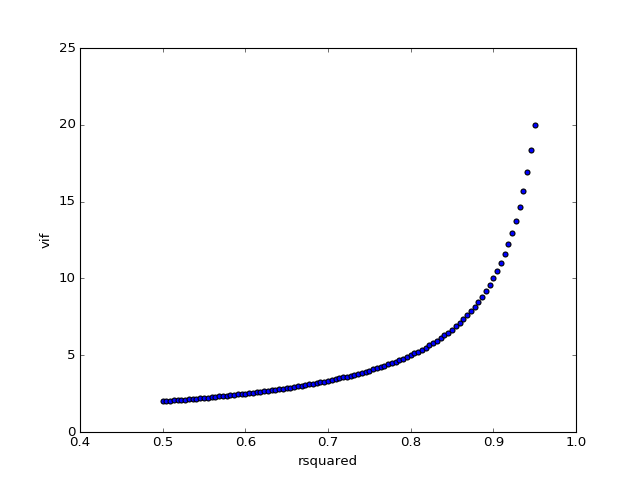

In [20]:
rsquared = np.linspace(0.5, 0.95, 100)
vif = 1 / (1 - rsquared)

pd.DataFrame({
    'rsquared': rsquared,
    'vif': vif
}).plot(kind = 'scatter', x = 'rsquared', y = 'vif')

Here, we get a bit more insight into the classic VIF thresholds.

A VIF of 5 means that your r-squared is sitting around 0.8 on the predictor regression.

A VIF of 10 means that your r-squared is sitting around 0.9 on the predictor regression.

Essentially what we are saying is that we're comfortable saying that the collinearity is acceptable below a 0.8 r-squared threshold. How accurate is that? Well I'm not about to argue with the standards of an entire scientific community... I'm just a guy who likes basketball...

Let's give VIF a try.

In [21]:
# Load library with vif function
%R library(car)

# Run vif analysis
%R as.data.frame(vif(allNbaLogReg))

,vif(allNbaLogReg)
advancedStats_WS,2.467044
advancedStats_VORP,2.467044


Doesn't actually look like there's much collinearity here! The value is not 0, so it definitely exists, but is well below our threshold of 5. It does still bother me a little bit because just _**visually**_, there clearly is collinearity! The band might be wide enough to escape the threshold, but there definitely is, right?

<img src="https://68.media.tumblr.com/e6626cfa0fe8a0688164cad15a8ab17f/tumblr_nqaly8YmeU1ur2po4o1_500.gif" width="400">

### LDA + Logistic Regression
Let me actually try a dimension reduction algorithm to see if I can get any closer in my predictions! This seems perfect for LDA dimension reduction because LDA will help us find the axis of greatest separation. We then end up with one predictor variable (the first LDA component) which we can then pass through logistic regression.

In [22]:
%%R -o allNbaLogRegLdaCoefs

# Load MASS package to access LDA function
library(MASS)

# Fit the LDA model
allNbaLda = lda(accolades_all_nba ~ advancedStats_VORP + advancedStats_WS, data = playerAggDfAllNbaAllStar)

# Apply the model back on the data to get the reduced dimension
allNbaLdaPred = predict(allNbaLda, newdata = playerAggDfAllNbaAllStar[,c('advancedStats_VORP', 'advancedStats_WS')])

# Store the first LDA component back into our dataframe
playerAggDfAllNbaAllStar['lda_first_comp'] = allNbaLdaPred$x[,'LD1']

# Fit the logistic regression model
allNbaLogRegLda = glm(accolades_all_nba ~ lda_first_comp, data = playerAggDfAllNbaAllStar, family = binomial(link = 'logit'))

# # Store coefficients in dataframe to view back in python
allNbaLogRegLdaCoefs = as.data.frame(summary(allNbaLogRegLda)$coefficients)

In [23]:
# View coefficients of logistic regression model on first LDA component
allNbaLogRegLdaCoefs

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),5.821242,0.152874,38.078724,0.000000e+00
lda_first_comp,1.852801,0.060778,30.484941,4.126607e-204


Okay, our coefficient is positive now, but we have to be aware of everything that's going on. Our unit increase is now on our LDA component, the axis of greatest separation. This is some combinatino of WS and VORP, but is a bit abstracted now because we can't tie it directly to WS or VORP without looking at any of the loadings on the variables.

However, we do only have one variable, and with every unit increase in that variable, we _**increase**_ our log-odds by 1.85, and I can only assume that our probability has switched to now evaluating the probability of _**being on an all-NBA team**_ because of the positive coefficient.

Let's take a look at the ROC curve here.

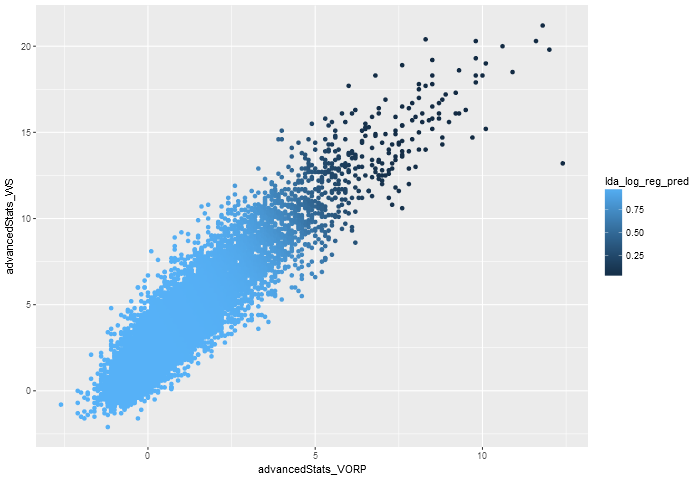

In [24]:
%%R -w 700 -u px

# Add predictions to dataframe
playerAggDfAllNbaAllStar['lda_log_reg_pred'] = predict(allNbaLogRegLda, playerAggDfAllNbaAllStar[c('lda_first_comp')], type = 'response')

# Plot WS vs VORP scatter with predictions colored in
allNbaPlotLogLdaReg = ggplot(
    NULL
) +
geom_point(
    data = playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = lda_log_reg_pred
    )
)

allNbaPlotLogLdaReg

The gradient has in fact changed! Not by much, but it has definitely changed. The gradient before was a bit more horizontal, but we see now that it changes more along with the axis of separation, which is diagonal. It almost looks like we did it with PCA as well, it looks to be in the axis of greatest varaince as well (roughly).

Let's check out the ROC curve.

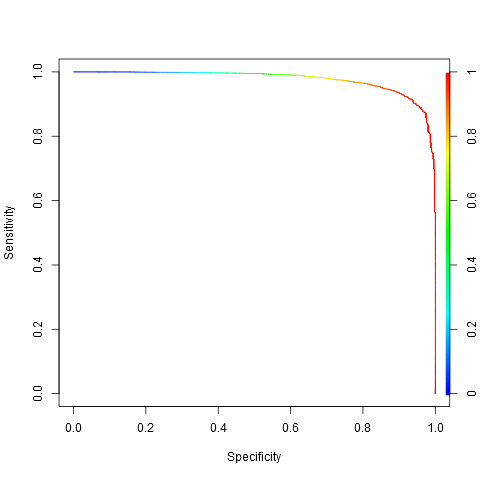

In [25]:
%%R

# Perform prediction
logRegLdaPredObj = prediction(playerAggDfAllNbaAllStar['lda_log_reg_pred'], playerAggDfAllNbaAllStar['accolades_all_nba'])

# Run performance evaluation for the metrics 'true positive rate' and 'false positive rate'
logRegLdaRocEval = performance(logRegLdaPredObj, 'sens', 'spec')
plot(logRegLdaRocEval, colorize = T)

In [26]:
# Retrieve the iterative cut-off sensitivity analysis that logistic regression did behind the scenes
%R logRegLdaCutoffs = data.frame(cut = logRegLdaRocEval@alpha.values[[1]], sens = logRegLdaRocEval@x.values[[1]], spec = logRegLdaRocEval@y.values[[1]])

# Calculate the metrics sensitivity + specificity. This will help us gauge the accuracy of both classes simultaneously.
#   E.g. if we were guessing each class 100% correctly (there is a very distinct decision boundary), then we would have 1 + 1 = 2
%R logRegLdaCutoffs['sens_plus_spec'] = logRegLdaCutoffs['sens'] + logRegLdaCutoffs['spec']

# See the last few rows of this dataframe where the sensitivity + specificity are at its max
%R tail(logRegLdaCutoffs[order(logRegLdaCutoffs$sens_plus_spec),])

,cut,sens,spec,sens_plus_spec
1821,0.972548,0.956175,0.893537,1.849712
1802,0.974116,0.960159,0.889605,1.849765
1803,0.974060,0.960159,0.889684,1.849843
1804,0.974002,0.960159,0.889841,1.850001
1805,0.973946,0.960159,0.889998,1.850158
1806,0.973888,0.960159,0.890077,1.850236


Okay, wow, in this space, the max we can achieve is 1.85 and the max we achieved with pure logistic regression is 1.866. We see that the split here is 96% / 89%, which is probably a bit less disirable than 94% / 92%, so let's not go any further for now.